[]

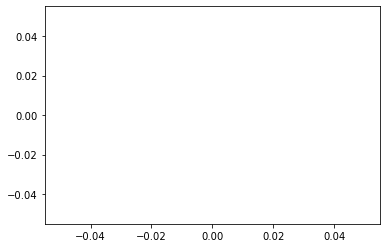

In [1]:
import matplotlib.pyplot as plt

plt.plot()

In [2]:
import matplotlib.pyplot as plt
import wandb
from tqdm.auto import tqdm
import os, sys
import time
import numpy as np
import collections
import torch
from torch import Tensor, nn
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler
from torchvision.transforms import Resize, CenterCrop
from typing import Iterable, Dict, Callable, Tuple
import torch.nn.functional as F
import matplotlib.pyplot as plt
from random import randrange
from copy import deepcopy

from nnunet.training.model_restore import restore_model
import batchgenerators
from batchgenerators.transforms.local_transforms import *
from batchgenerators.dataloading.single_threaded_augmenter import SingleThreadedAugmenter
from batchgenerators.dataloading.multi_threaded_augmenter import MultiThreadedAugmenter
from batchgenerators.utilities.file_and_folder_operations import *
from nnunet.paths import preprocessing_output_dir
from nnunet.training.dataloading.dataset_loading import *
from nnunet.training.network_training.nnUNetTrainerV2 import nnUNetTrainerV2
from nnunet.run.load_pretrained_weights import load_pretrained_weights

sys.path.append('..')
from dataset import CalgaryCampinasDataset, ACDCDataset, MNMDataset
from utils import EarlyStopping, epoch_average, average_metrics
from model.dae import AugResDAE
from model.unet import UNet2D
from model.wrapper import Frankenstein
from losses import MNMCriterionAE, SampleDice, UnetDice
from trainer.ae_trainer import AETrainerACDC

nnUnet_prefix = '../../../nnUNet/'



# define single image dataloader from batchgenerator example here:
# https://github.com/MIC-DKFZ/batchgenerators/blob/master/batchgenerators/examples/example_ipynb.ipynb
class SingleImageMultiViewDataLoader(batchgenerators.dataloading.data_loader.SlimDataLoaderBase):
    def __init__(self, data: ACDCDataset, batch_size: int = 2, return_orig: str = False):
        super(SingleImageMultiViewDataLoader, self).__init__(data, batch_size)
        # data is now stored in self._data.
        self.return_orig = return_orig
    
    def generate_train_batch(self):
        
        data = self._data[randrange(len(self._data))]
        img = data['input'].numpy().astype(np.float32)
        tar = data['target'][0].numpy().astype(np.float32)
        
        img_batched = np.tile(img, (self.batch_size, 1, 1, 1))
        tar_batched = np.tile(tar, (self.batch_size, 1, 1, 1))
        # now construct the dictionary and return it. np.float32 cast because most networks take float
        out = {'data': img_batched, 
               'seg':  tar_batched}
        
        # if the original data is also needed, activate this flag to store it where augmentations
        # cant find it.
        if self.return_orig:
            out['data_orig']   = data['input'].unsqueeze(0)
            out['target_orig'] = data['target'].unsqueeze(0)
        
        return out
    



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



In [3]:
original_transforms = (
    batchgenerators.transforms.resample_transforms.SimulateLowResolutionTransform,
    batchgenerators.transforms.noise_transforms.GaussianNoiseTransform,
    batchgenerators.transforms.utility_transforms.RemoveLabelTransform,
    batchgenerators.transforms.utility_transforms.RenameTransform,
    batchgenerators.transforms.utility_transforms.NumpyToTensor
)



In [13]:
scale = 200.
local_transforms = [
    #BrightnessGradientAdditiveTransform(scale=200, max_strength=4, p_per_sample=1, p_per_channel=1),
    #LocalGammaTransform(scale=200, gamma=(2, 5), p_per_sample=1, p_per_channel=1),
    #LocalSmoothingTransform(scale=200, smoothing_strength=(0.5, 1), p_per_sample=1, p_per_channel=1),
    LocalContrastTransform(scale=scale, new_contrast=(1, 3), p_per_sample=1, p_per_channel=1),
]

train_transforms = local_transforms # + [t for t in train_loader.transform.transforms if isinstance(t, original_transforms)]
    
train_augmentor = batchgenerators.transforms.abstract_transforms.Compose(train_transforms)
### - Load dataset and init batch generator
train_data = ACDCDataset(data='val', debug=False)

train_gen = SingleImageMultiViewDataLoader(train_data, batch_size=4, return_orig=True)
#train_gen = SingleThreadedAugmenter(train_gen, train_augmentor)
train_gen = MultiThreadedAugmenter(train_gen, train_augmentor, 1, 1, seeds=None)

loading dataset
loading all case properties


In [14]:
b = train_gen.next()
transformed = b['data'].squeeze()
img = b['data_orig'].squeeze()

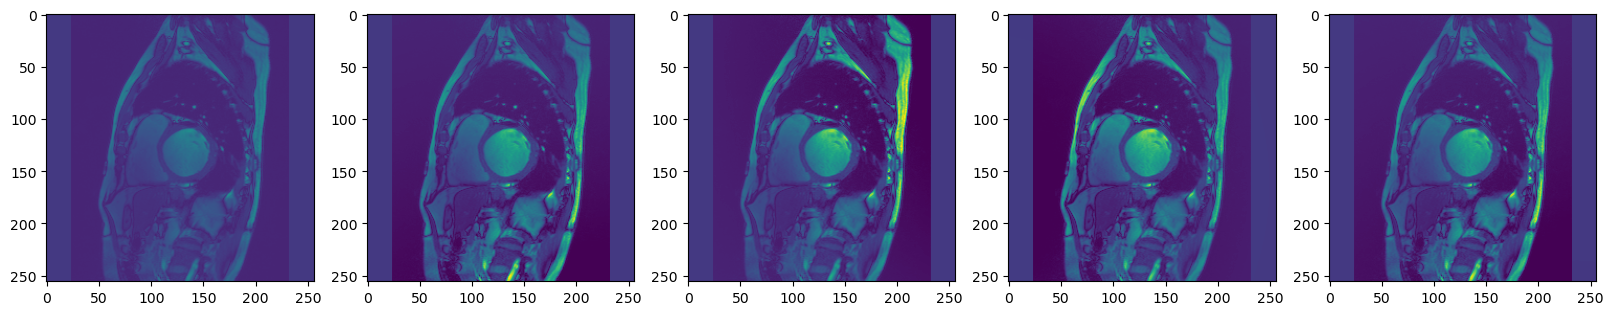

In [135]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

axes[0].imshow(img, vmin=-2, vmax=10)

for i in range(4):
    axes[i+1].imshow(transformed[i], vmin=-2, vmax=10)

In [25]:
class Frankenstein(nn.Module):
    """Wrapper class for segmentation models and feature transformations.

    Wraps (a copy of) the segmentation model and attaches feature
    trasformations to it via hooks (at potentially various positions
    simultaneously). Additionally, it provides control utilities for the
    hooks as well as different types for inference and training.
    """

    def __init__(
        self,
        seg_model: nn.Module,
        transformations: nn.ModuleDict,
        disabled_ids: list = [],
        copy: bool = True,
    ):
        super().__init__()
        self.seg_model = deepcopy(seg_model) if copy else seg_model

        self.transformations = transformations
        self.disabled_ids = disabled_ids
        self.transformation_handles = {}
        self.train_transformation_handles = {}
        self.inspect_transformation_handles = {}
        self.training_data = {}
        self.inspect_data = {}

    def hook_train_transformations(self, transformations: Dict[str, nn.Module]) -> None:
        for layer_id in transformations:
            layer = self.seg_model.get_submodule(layer_id)
            hook = self._get_train_transformation_hook(
                transformations[layer_id], layer_id
            )
            self.train_transformation_handles[
                layer_id
            ] = layer.register_forward_pre_hook(hook)

    def hook_transformations(
        self, transformations: Dict[str, nn.Module], n_samples: int
    ) -> None:
        for layer_id in transformations:
            layer = self.seg_model.get_submodule(layer_id)
            hook = self._get_transformation_hook(transformations[layer_id], n_samples)
            self.transformation_handles[layer_id] = layer.register_forward_pre_hook(
                hook
            )
            
    def hook_inspect_transformation(
        self, 
        transformations: Dict[str, nn.Module], 
    ) -> None:
        for layer_id in transformations:
            if layer_id not in self.disabled_ids:
                layer = self.seg_model.get_submodule(layer_id)
                hook  = self._get_inspect_transformation_hook(transformations[layer_id], layer_id)
                self.inspect_transformation_handles[layer_id] = layer.register_forward_pre_hook(hook)
            

#     def _get_train_transformation_hook(
#         self, transformation: nn.Module, layer_id: str
#     ) -> Callable:
#         def hook(module: nn.Module, x: Tuple[Tensor]) -> Tensor:
#             x_in, *_ = x  # tuple, alternatively use x_in = x[0]
#             x_orig = x_in[:1]
#             #x_views = x_in[1:]
#             x_in_denoised = transformation(x_in)
            
#             if layer_id not in self.disabled_ids:
#                 mse = nn.functional.mse_loss(x_in_denoised, x_orig.detach(), reduction="mean")

#                 training_data = {
#                     "mse": mse,
#                 }

#                 self.training_data[layer_id] = training_data

#             #return torch.cat([x_orig, x_in_denoised], dim=0)
#             return x_in_denoised
            
#         return hook
    
    
    def _get_train_transformation_hook(
        self, transformation: nn.Module, layer_id: str
    ) -> Callable:
        def hook(module: nn.Module, x: Tuple[Tensor]) -> Tensor:
            x_in, *_ = x  # tuple, alternatively use x_in = x[0]
            #print(x_in.shape, x_in.shape[0] // 2)
            batch_size = x_in.shape[0] // 2
            x_orig, x_views  = torch.split(x_in, batch_size)
            x_in_denoised = transformation(x_views)
            
            if layer_id not in self.disabled_ids:
                mse = nn.functional.mse_loss(x_in_denoised, x_orig.detach(), reduction="mean")

                training_data = {
                    "mse": mse,
                }

                self.training_data[layer_id] = training_data

            return torch.cat([x_orig, x_in_denoised], dim=0)
            #return x_in_denoised
            
        return hook
    

    def _get_transformation_hook(
        self, transformation: nn.Module, n_samples: int = 1
    ) -> Callable:
        def hook(module: nn.Module, x: Tuple[Tensor]) -> Tensor:
            x_in, *_ = x  # weird tuple, can use x_in = x[0]
            if n_samples == 0:
                return x
            elif n_samples == -1:
                x_in_new = transformation(x_in)
                return x_in_new
            else:
                x_in_new = x_in.unsqueeze(1).repeat(1, n_samples, 1, 1, 1).flatten(0, 1)
                x_in_new = transformation(x_in_new)
                return torch.cat([x_in, x_in_new], dim=0)

        return hook
            
        
#     def _get_inspect_transformation_hook(
#             self, 
#             transformation: nn.Module, 
#             layer_id: str, 
#             n_samples: int,
#             arch: str = 'ae',
#         ) -> Callable:
        
#         @torch.no_grad()
#         def hook(module: nn.Module, x: Tuple[Tensor]) -> Tensor:
#             x_in, *_ = x  # weird tuple, can use x_in = x[0]
#             if n_samples == 0:
#                 return x
#             elif n_samples == -1:
#                 mu, log_var, x_in_new = transformation(x_in)
#             else:
#                 x_in_new = x_in.unsqueeze(1).repeat(1, n_samples, 1, 1, 1).flatten(0, 1)
#                 if arch == 'ae':
#                     x_in_new = transformation(x_in_new)
#                 elif arch == 'res_ae':
#                     x_in_new, prior, residual = transformation(x_in_new)
#                 x_in_new = torch.cat([x_in, x_in_new], dim=0)
                
#             if layer_id not in self.disabled_ids:
#                 training_data = {
#                     'input'  : x_in_new[ :1],
#                     'recon'  : x_in_new[1: ],
#                 }
                
#                 if arch == 'res_ae':
#                     training_data['prior'] = prior
#                     training_data['residual'] = residual
                
#                 self.inspect_data[layer_id] = training_data
            
#             return x_in_new
        
#         return hook
   
    
    def _get_inspect_transformation_hook(
            self, 
            transformation: nn.Module, 
            layer_id: str, 
        ) -> Callable:
        
        @torch.no_grad()
        def hook(module: nn.Module, x: Tuple[Tensor]) -> Tensor:
            x_in, *_ = x  # weird tuple, can use x_in = x[0]
#             #print(x_in.shape, x_in.shape[0] // 2)
#             batch_size = x_in.shape[0] // 2
#             x_orig, x_views  = torch.split(x_in, batch_size)
#             x_in_denoised = transformation(x_views)
            
            x_orig = x_in[:1]
            x_in_denoised = transformation(x_in)
            residuals     = x_in_denoised - x_in
                
            if layer_id not in self.disabled_ids:
                data = {
                    'input'     : x_in,
                    'denoised'  : x_in_denoised,
                    'residuals' : residuals
                }
                
                self.inspect_data[layer_id] = data
            
            return torch.cat([x_orig, x_in_denoised[1:]], dim=0)
        
        return hook
    
    

    def remove_train_transformation_hook(self, layer_id: str) -> None:
        self.train_transformation_handles[layer_id].remove()

    def remove_transformation_hook(self, layer_id: str) -> None:
        self.transformation_handles[layer_id].remove()
        
    def remove_inspect_transformation_hook(self, layer_id: str) -> None:
        self.inspect_transformation_handles[layer_id].remove()

    def remove_all_hooks(self):
        if hasattr(self, "train_transformation_handles"):
            for handle in self.train_transformation_handles:
                self.train_transformation_handles[handle].remove()
            self.train_transformation_handles = {}

        if hasattr(self, "transformation_handles"):
            for handle in self.transformation_handles:
                self.transformation_handles[handle].remove()
            self.transformation_handles = {}
            
        if hasattr(self, 'inspect_transformation_handles'):
            for handle in self.inspect_transformation_handles:
                self.inspect_transformation_handles[handle].remove()
            self.inspect_transformation_handles = {}
        

    def freeze_seg_model(self):
        self.seg_model.eval()
        for param in self.seg_model.parameters():
            param.requires_grad = False

    def set_number_of_samples_to(self, n_samples: int):
        self.n_samples = n_samples

    def disable(self, layer_ids: list) -> None:
        for layer_id in layer_ids:
            self.transformations[layer_id].turn_off()

    def enable(self, layer_ids: list) -> None:
        for layer_id in layer_ids:
            self.transformations[layer_id].turn_on()

    def forward(self, x: Tensor):
        return self.seg_model(x)

In [26]:
ROOT = '../../'
middle = 'unet8_'
pre = 'acdc'
it = '0'
name = f'{pre}_{middle}{it}'

model_path = f'{ROOT}pre-trained-tmp/trained_UNets/{name}_best.pt'
state_dict = torch.load(model_path)['model_state_dict']
n_chans_out = 4
unet = UNet2D(n_chans_in=1, 
              n_chans_out=n_chans_out, 
              n_filters_init=8, 
              dropout=False)
unet.load_state_dict(state_dict)    




disabled_ids = ['shortcut0', 'shortcut1', 'shortcut2']
DAEs = nn.ModuleDict({'up3': AugResDAE(in_channels = 64, 
                                       in_dim      = 32,
                                       latent_dim  = 256,
                                       depth       = 3,
                                       block_size  = 4)})


for layer_id in disabled_ids:
    DAEs[layer_id] = nn.Identity()
model = Frankenstein(seg_model=unet,
                     transformations=DAEs,
                     disabled_ids=disabled_ids,
                     copy=True)

model_path = f'{ROOT}pre-trained-tmp/trained_AEs/acdc_AugResDAE{it}_localAug_multiImgSingleView_res_balanced_same_best.pt'
state_dict = torch.load(model_path)['model_state_dict']
model.load_state_dict(state_dict)

<All keys matched successfully>

In [27]:
model.hook_inspect_transformation(model.transformations)

In [78]:
b = train_gen.next()
x_in = torch.cat([b['data_orig'], torch.tensor(b['data'])], dim=0)
x_in.shape
# transformed = b['data']
# img = b['data_orig'].squeeze()

torch.Size([5, 1, 256, 256])

In [79]:
tmp = model(x_in).detach()

In [80]:
feature_maps          = model.inspect_data['up3']['input'].detach()[:, 0]#.mean(1)
denoised_feature_maps = model.inspect_data['up3']['denoised'].detach()[:, 0]#.mean(1)
feature_map_residuals = model.inspect_data['up3']['residuals'].detach()[:, 0]#.mean(1)

In [81]:
tmp.shape

torch.Size([5, 4, 256, 256])

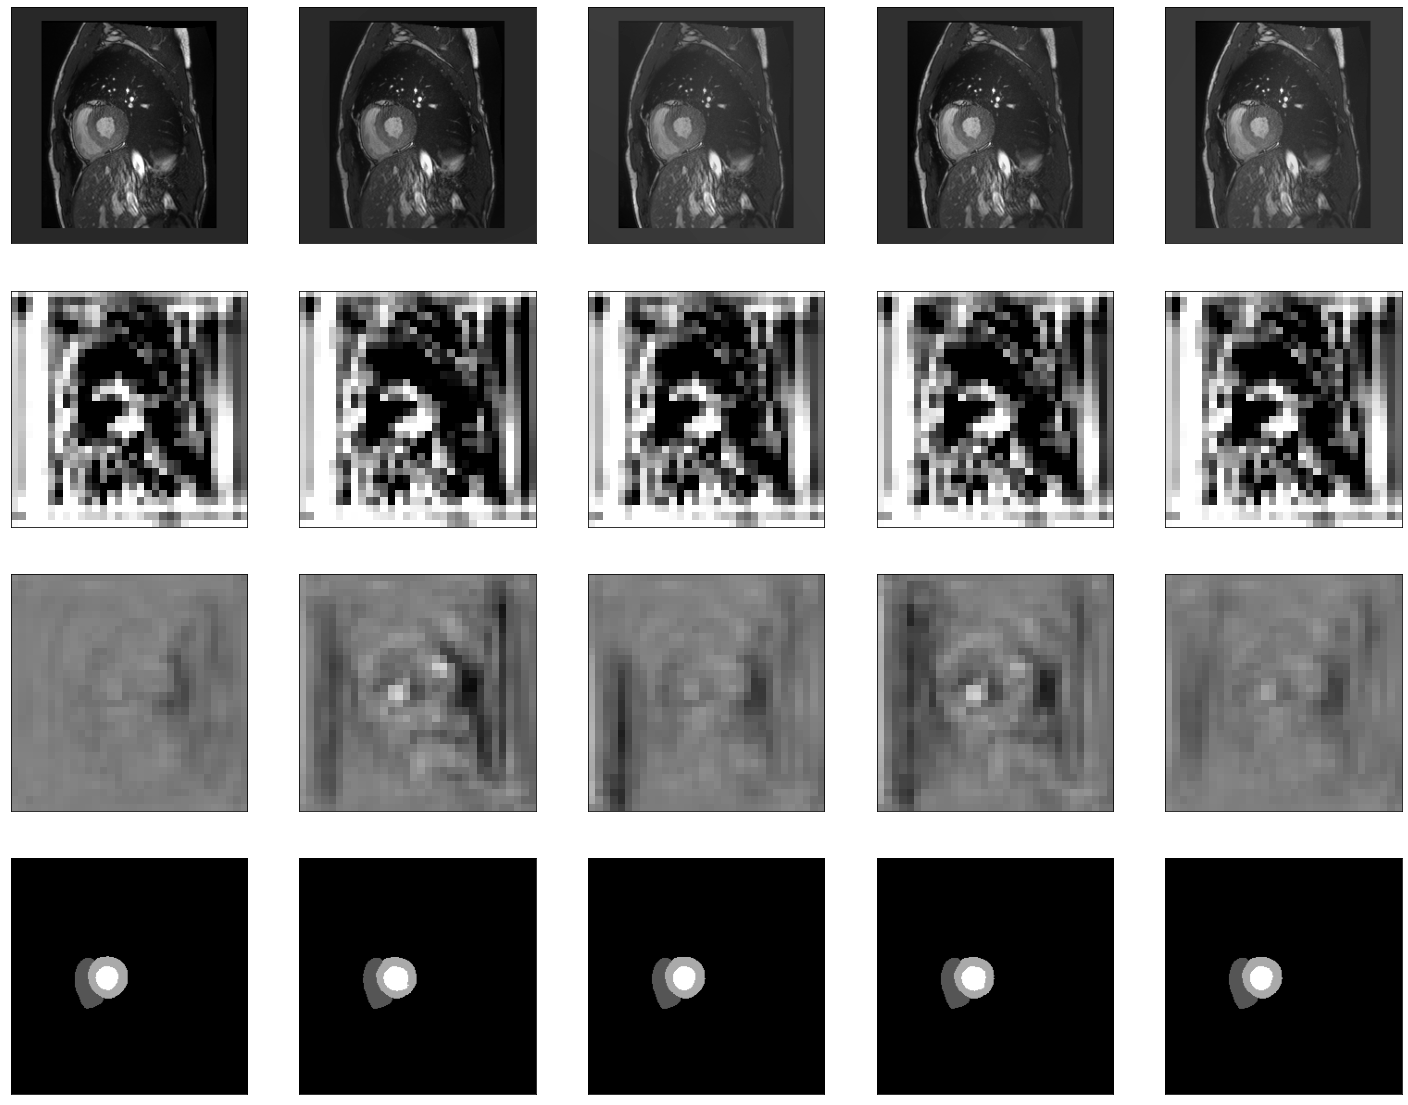

In [84]:
vmin = -4/4
vmax =  4/4
cmap = 'gray'

fig, axs = plt.subplots(4, 5, figsize=(25,20))

for i in range(5):
    axs[0, i].imshow(x_in[i, 0], cmap=cmap)
    
#     if i>0:
#         axs[1, i].imshow(feature_maps[0] - feature_maps[i], vmin=vmin, vmax=vmax, cmap=cmap)
#         axs[2, i].imshow(denoised_feature_maps[0] - denoised_feature_maps[i], vmin=vmin, vmax=vmax, cmap=cmap)
#     elif i == 0:
    axs[1, i].imshow(feature_maps[i], vmin=vmin, vmax=vmax, cmap=cmap)
    axs[2, i].imshow(feature_maps[i] - denoised_feature_maps[i], vmin=vmin, vmax=vmax, cmap=cmap)
    
    #axs[3, i].imshow(feature_map_residuals[i], vmin=vmin, vmax=vmax, cmap=cmap)
    #axs[3, i].imshow(feature_maps[i] - denoised_feature_maps[i], vmin=vmin, vmax=vmax, cmap=cmap)
    axs[3, i].imshow(torch.argmax(tmp[i], dim=0), cmap=cmap)
    
    for j in range(4):
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])
        
#fig.savefig("../../results-tmp/results/eval/local_aug_actVis.jpg", bbox_inches='tight', dpi=400)

In [83]:
torch.unique(torch.argmax(tmp[i], dim=0))

tensor([0, 1, 2, 3])

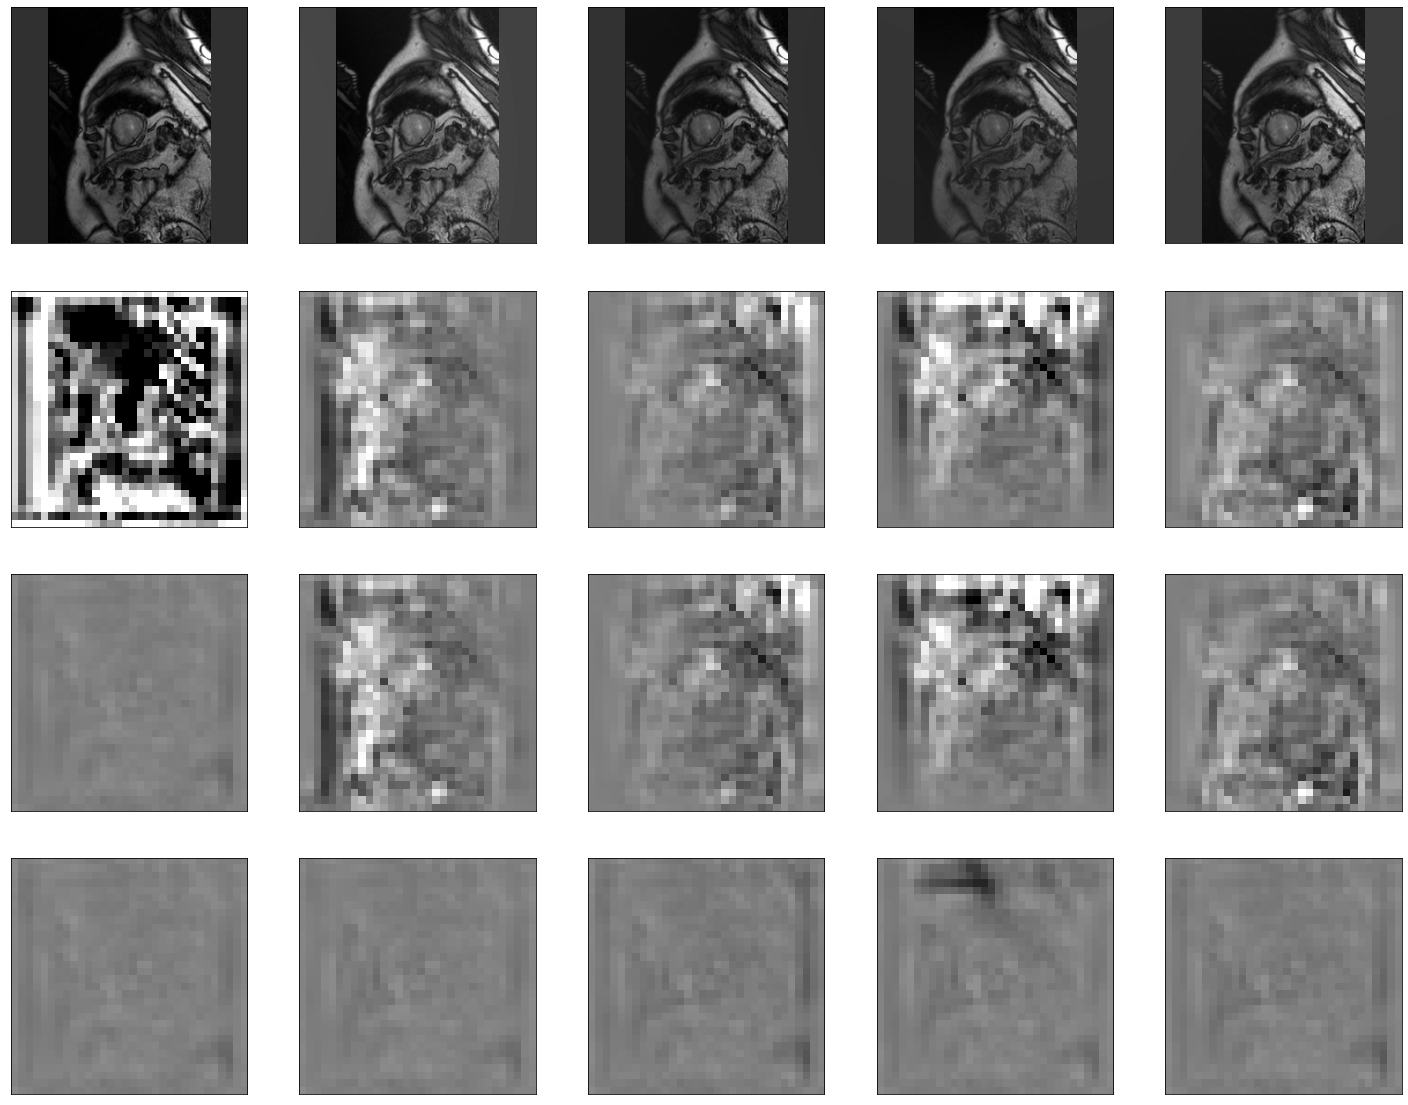

In [24]:
vmin = -4/4
vmax =  4/4
cmap = 'gray'

fig, axs = plt.subplots(4, 5, figsize=(25,20))

for i in range(5):
    axs[0, i].imshow(x_in[i, 0], cmap=cmap)
    
    if i>0:
        axs[1, i].imshow(feature_maps[0] - feature_maps[i], vmin=vmin, vmax=vmax, cmap=cmap)
        axs[2, i].imshow(denoised_feature_maps[0] - denoised_feature_maps[i], vmin=vmin, vmax=vmax, cmap=cmap)
    elif i == 0:
        axs[1, i].imshow(feature_maps[i], vmin=vmin, vmax=vmax, cmap=cmap)
        axs[2, i].imshow(feature_maps[i] - denoised_feature_maps[i], vmin=vmin, vmax=vmax, cmap=cmap)
    
    #axs[3, i].imshow(feature_map_residuals[i], vmin=vmin, vmax=vmax, cmap=cmap)
    axs[3, i].imshow(feature_maps[i] - denoised_feature_maps[i], vmin=vmin, vmax=vmax/4, cmap=cmap)
    
    for j in range(4):
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])
        
#fig.savefig("../../results-tmp/results/eval/local_aug_actVis.jpg", bbox_inches='tight', dpi=400)